# Predict Future Sales

##### We will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

##### We are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

File descriptions : 
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.

Data fields :
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, -February 2013 is 1,..., October 2015 is 33

In [2]:
# Libraries 
import pandas as pd
import numpy as np
#Viz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Time Serie
import statsmodels.api as sm #to plot the decomposed time series
from statsmodels.tsa.ar_model import AR #Autocorrelation
from pandas.plotting import lag_plot #Autocorrelation plot
from statsmodels.tsa.stattools import adfuller # Stationarity
from fbprophet import Prophet 

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


# Database

In [3]:
# sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
sales_train = pd.read_csv('sales_train.csv')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Data cleaning 

In [4]:
sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [5]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [6]:
sales_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


In [7]:
# First I need to convert the date column from sales_train base to date type
sales_train.date = pd.to_datetime(sales_train.date)

# Analysis & Visualisation 

In [119]:
#How many shop do we have ? 
print('Sales_train : ',sales_train.shop_id.nunique(),' shops')
#and for items ?
print('Sales_train : ',sales_train.item_id.nunique(),' items')

Sales_train :  60  shops
Sales_train :  21807  items


In [120]:
# I need the information (min,max,mean,sum) for each shop for each month  
monthly_sales=sales_train.groupby(["shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg(
    {"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})
#replace name to be more understandable
monthly_sales.columns.set_levels(['end', 'mean', 'start', 'sum'],level=1,inplace=True)
monthly_sales.head(15)

date             item_price item_cnt_day
                        min         max       mean          sum
shop_id item_id                                                
0       30       15.02.2013  26.02.2013      265.0         31.0
        31       15.02.2013  26.02.2013      434.0         11.0
        32       03.01.2013  31.01.2013      221.0         16.0
        33       03.01.2013  28.01.2013      347.0          6.0
        35       01.02.2013  31.01.2013      247.0         15.0

##### The objective is to predict sales for the next month with a store-item combination.

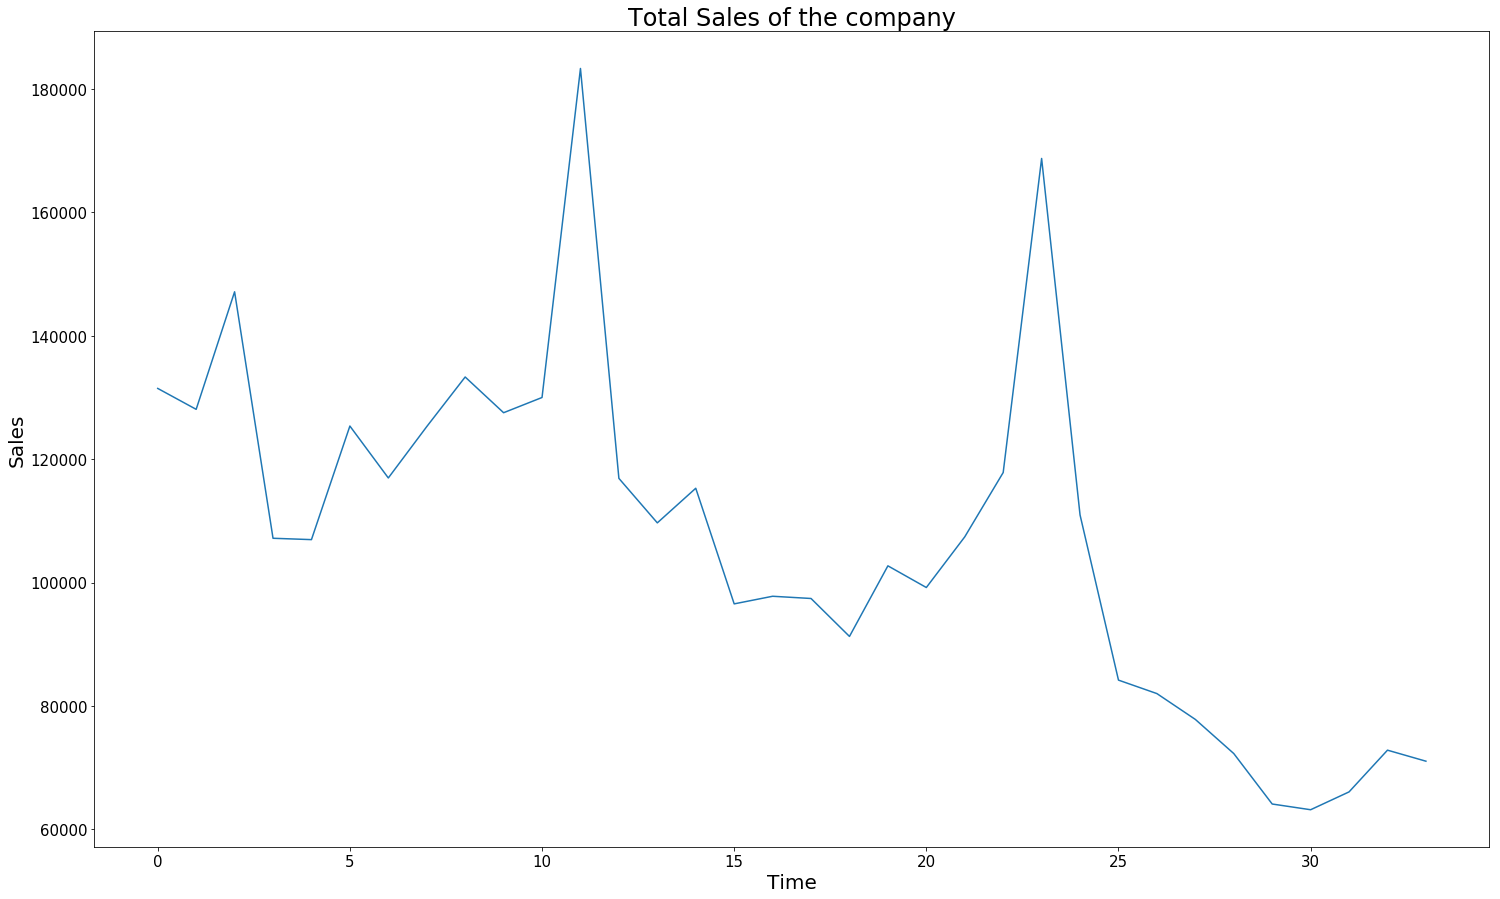

In [123]:
# Sales per month(January 2013 is 0 to October 2015 is 33)
plt.figure(figsize=(25,15))
date_sales=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum().astype('float')
plt.title('Total Sales of the company',fontsize=24)
plt.xlabel('Time',fontsize=20)
plt.xticks(fontsize=15)
plt.ylabel('Sales',fontsize=20)
plt.yticks(fontsize=15)
plt.plot(date_sales)
plt.show()
# unexpected increase sales during November 2013(11) and November 2014 : christmas season
# but in general, there is a decrease in sales 

# Time Series

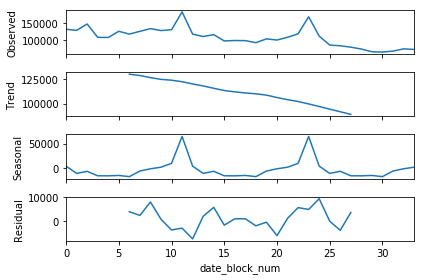

In [124]:
date_sales=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum().astype('float')
#12 months
res = sm.tsa.seasonal_decompose(date_sales,freq=12,model="additive")
resplot = res.plot()
#it seems that there is a seasonality as seen previously

In [125]:
# the time serie is it stationarity ? (if its mean and variance do not vary over time)
#H 0: The data is not stationary
#H 1: The data is stationary

result = adfuller(date_sales)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
# With a p-value of .14%  I do not reject the null hypothesis,
# And conclude that the data is not stationary.

ADF Statistic: -2.395704
p-value: 0.142953
Critical Values:
	1%: -3.646
	5%: -2.954
	10%: -2.616


## Checking for Autocorrelation (AR)

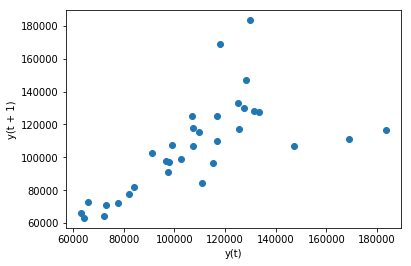

In [126]:
#I can check for autocorrelation in the data using a lag plot.
#AR(1) is a first-order autoregression model.
lag_plot(date_sales)
plt.show()
#A "line" along the diagonal shows that there is an autoregressive relationship.
#The series is explained by its past values rather than by other variables.

In [128]:
train,test=date_sales[:-20],date_sales[-20:]
model = AR(date_sales) # AR = Auto Regressive Model
model_fit = model.fit(maxlag = 12)
predictions = model_fit.predict(start = len(train), end = len(train) + len(test)-1,
                               dynamic = False)
#model_fit.params

In [129]:
predictions2 = model_fit.predict(start = len(train), end = len(train) + len(test)-1,
                               dynamic = False)
#predictions2

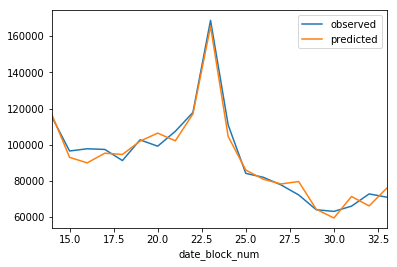

In [131]:
comparison = pd.DataFrame({'observed':test, 'predicted':round(predictions2,1)}).plot()
plt.
plt.show()

## Prophet

In [47]:
date_sales=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum() 
date_sales.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
date_sales=date_sales.reset_index()
date_sales.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [48]:
#The input to Prophet is always a dataframe with two columns: ds and y. 
#The ds (datestamp) column should be of a date format. 
#The y column must be numeric, and represents the measurement we wish to forecast.
date_sales.columns=['ds','y'] 

In [50]:
date_sales['y_orig'] = date_sales['y'] # to save a copy of the original data. 
date_sales['y'] = np.log(date_sales['y']) # log-transform y

In [53]:
model = Prophet() #instantiate Prophet
model.fit(date_sales); #fit the model with my dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/Eleonore/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [56]:
future_data = model.make_future_dataframe(periods=6, freq = 'm')
forecast_data = model.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
35,2015-11-30,2.438592,2.428923,2.448579
36,2015-12-31,2.451704,2.433467,2.472143
37,2016-01-31,2.371913,2.339560,2.404607
38,2016-02-29,2.382532,2.333889,2.426930
39,2016-03-31,2.392727,2.327671,2.452049


Figure(720x432)


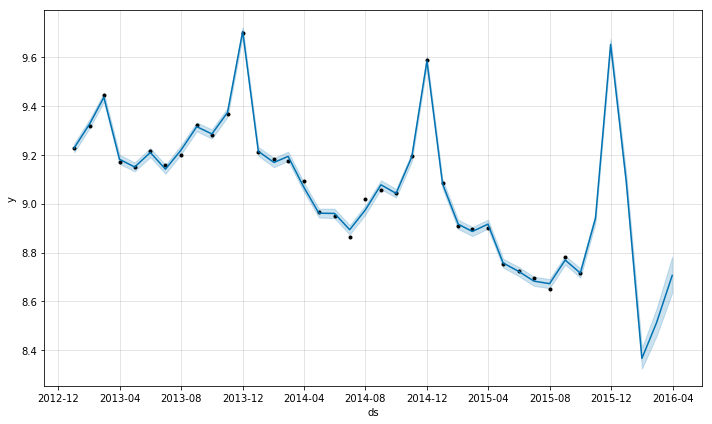

In [199]:
print(model.plot(forecast_data))

Figure(648x432)


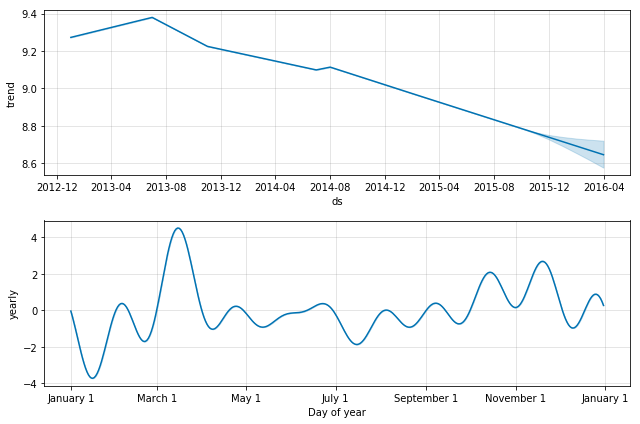

In [200]:
print(model.plot_components(forecast_data))